In [77]:
import os

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import (BatchNormalization, Conv2D, Conv2DTranspose, Dense,
                          Dropout, Flatten, GaussianNoise, LeakyReLU, Reshape)
from keras.models import Sequential
from keras.optimizers import Adam
from PIL import Image

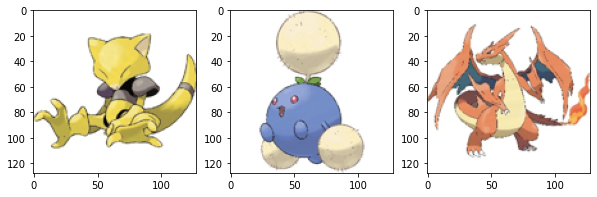

In [78]:
pokemon_dataset = []
# Load all the images in the dataset
for filename in os.listdir("pokemon_dataset"):
    # img = mpimg.imread("pokemon_dataset/" + filename)
    img = Image.open("pokemon_dataset/" + filename)
    # Downsample the image to 128x128
    img = img.resize((128, 128))
    # Convert the image to a numpy array
    img = np.array(img)
    pokemon_dataset.append(img)

# View the first few images side by side
plt.figure(figsize=(10, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(pokemon_dataset[i])

In [79]:
# Convert the list to a numpy array
pokemon_dataset = np.array(pokemon_dataset)

# Check the size of the images
pokemon_dataset.shape

(819, 128, 128, 3)

In [80]:
img_shape = pokemon_dataset[0].shape
noise_size = 128

In [81]:
def build_generator(latent_dim):
    # Input to the generator is noise
    noise_shape = (latent_dim,)
    
    model = Sequential()
    
    model.add(Dense(128*16*16, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Reshape((16, 16, 128)))

    # Upsample to 32x32
    model.add(Conv2DTranspose(128, kernel_size=4, strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # Upsample to 64x64
    model.add(Conv2DTranspose(128, kernel_size=4, strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # Upsample to 128x128
    model.add(Conv2DTranspose(128, kernel_size=4, strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(3, kernel_size=4, padding='same', activation='tanh'))

    model.summary()
    
    return model

In [82]:
# Build and compile the generator
generator = build_generator(noise_size)
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0005, 0.5))

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32768)             4227072   
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 32768)             0         
                                                                 
 batch_normalization_33 (Bat  (None, 32768)            131072    
 chNormalization)                                                
                                                                 
 reshape_6 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_27 (Conv2D  (None, 32, 32, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 32, 32, 128)     

In [83]:
def build_discriminator():
    model = Sequential()

    model.add(GaussianNoise(0.1, input_shape=img_shape))
    model.add(Conv2D(80, kernel_size=3, strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(80, kernel_size=3, strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    model.summary()
    
    return model

In [84]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_6 (GaussianN  (None, 128, 128, 3)      0         
 oise)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 80)        2240      
                                                                 
 leaky_re_lu_49 (LeakyReLU)  (None, 64, 64, 80)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 80)        57680     
                                                                 
 leaky_re_lu_50 (LeakyReLU)  (None, 32, 32, 80)        0         
                                                                 
 flatten_6 (Flatten)         (None, 81920)             0         
                                                     

In [85]:
def build_gan(generator, discriminator):
    # The discriminator is trained separately, so we it to not trainable
    discriminator.trainable = False
    # Combine the two models
    # Noise as input => generates fake images => discriminator outputs validity
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0005, 0.5))
    return model

In [86]:
gan = build_gan(generator, discriminator)

In [87]:
def latent_vectors(latent_dim, n_samples):
    # return np.random.normal(0, 1, (n_samples, latent_dim))
    latent_vec = np.random.randn(n_samples * latent_dim)
    latent_vec = latent_vec.reshape(n_samples, latent_dim)
    return latent_vec

In [88]:
def train(epochs, batch_size=128, save_interval=1000):
    X_train = pokemon_dataset

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    half_batch = int(batch_size / 2)

    d_losses = []
    g_losses = []

    try:
        for epoch in range(epochs):
            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of real images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = latent_vectors(noise_size, half_batch)

            # Generate a half batch of new images
            gen_imgs = generator.predict(noise)

            # Train the discriminator on real and fake images separately
            d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            # Average loss of real and fake images
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Create noise vectors as input for the generator
            noise = latent_vectors(noise_size, batch_size)

            # The generator wants the discriminator to label the generated samples as valid (ones)
            valid_y = np.ones((batch_size, 1))

            # Train the generator
            g_loss = gan.train_on_batch(noise, valid_y)

            # Append the losses for plotting
            d_losses.append(d_loss[0])
            g_losses.append(g_loss)

            # Plot the progress
            print("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))

            # If at save interval => save generated image samples & model
            if epoch % save_interval == 0:
                save_imgs(epoch)
                # Create the models folder if it does not exist
                if not os.path.exists('models'):
                    os.makedirs('models')
                generator.save(f'models/generator_{epoch}.h5')
    except KeyboardInterrupt:
        print("Training interrupted")
    finally:
        # Plot the losses
        plt.figure(figsize=(10, 5))
        plt.plot(d_losses, label="Discriminator Loss")
        plt.plot(g_losses, label="Generator Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        generator.save('models/generator_final.h5')

In [89]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = latent_vectors(noise_size, r * c)
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c, figsize=(30, 30))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i,j].axis('off')
            cnt += 1

    if not os.path.exists('generated_images'):
        os.makedirs('generated_images')
    fig.savefig(f"generated_images/gen_{epoch}.png")
    plt.close()

2024-07-28 20:52:43.739866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 367ms/step


2024-07-28 20:52:44.350692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-28 20:52:49.415533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0 [D loss: 0.704333] [G loss: 0.481027]
1/1 [==============================] - 0s 57ms/step
1 [D loss: 0.438071] [G loss: 0.431588]
1/1 [==============================] - 0s 17ms/step
2 [D loss: 0.397364] [G loss: 0.462758]
1/1 [==============================] - 0s 18ms/step
3 [D loss: 0.403133] [G loss: 0.562685]
1/1 [==============================] - 0s 16ms/step
4 [D loss: 0.366790] [G loss: 0.716558]
1/1 [==============================] - 0s 15ms/step
5 [D loss: 0.267223] [G loss: 0.848028]
1/1 [==============================] - 0s 21ms/step
6 [D loss: 0.274382] [G loss: 0.677978]
1/1 [==============================] - 0s 13ms/step
7 [D loss: 0.620622] [G loss: 0.448741]
1/1 [==============================] - 0s 19ms/step
8 [D loss: 0.818010] [G loss: 0.211935]
1/1 [==============================] - 0s 20ms/step
9 [D loss: 0.854646] [G loss: 0.067023]
1/1 [==============================] - 0s 18ms/step
10 [D loss: 0.784891] [G loss: 0.029437]
1/1 [==============================] - 

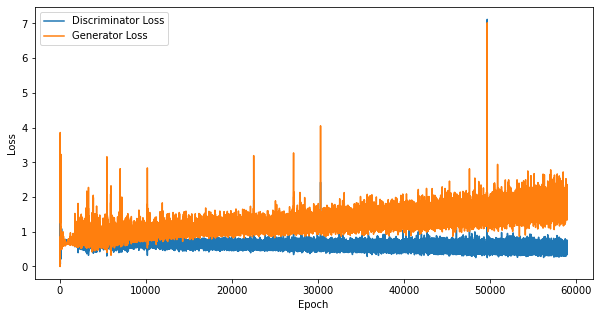

In [90]:
train(epochs=100_000, batch_size=32, save_interval=300)